In [32]:
%load_ext autoreload
%autoreload 2

import torch
from spaces import NSphereSpace
from visualization_utils.spheres import visualize_spheres_side_by_side

from encoders import get_mlp

import matplotlib.pyplot as plt

from simclr.simclr import SimCLR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


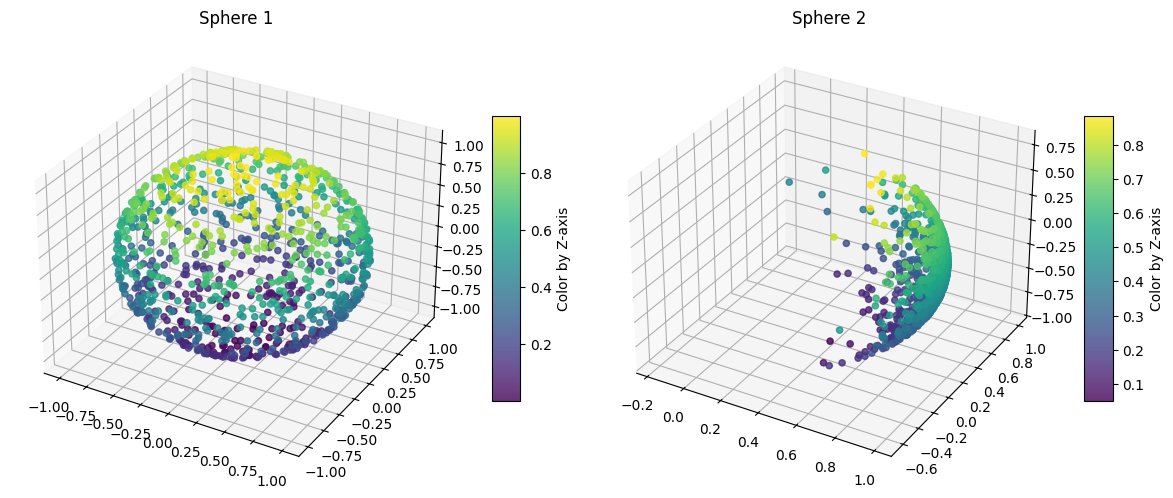

In [33]:
latent_dimension = 3 # Operate on a latent space dimension 3
data_dimension = 3 # Make data dimension identical
kappa = tau = 10 # Use 0.1 for kappa
normal_concentration_param = 0.1 # Default in Zimmerman's code

iterations = 2000
batch = 6144

# Initialize a unit hypersphere of dimension 3
sphere = NSphereSpace(latent_dimension)
ref = sphere.uniform(1)[0]
z1 = sphere.von_mises_fisher(ref, 0.1, 1000)

# Take a lot of samples for training

z2 = sphere.von_mises_fisher(ref, 10, 1000)
# z_aug = sphere.normal(z, normal_concentration_param, 1000)

visualize_spheres_side_by_side(plt, z1, z2)

# z, z_aug = sample_pairs()
# z_2, z_2_aug = sample_pairs_normal(1000)

# visualize_spheres_side_by_side(plt, z, z_aug)

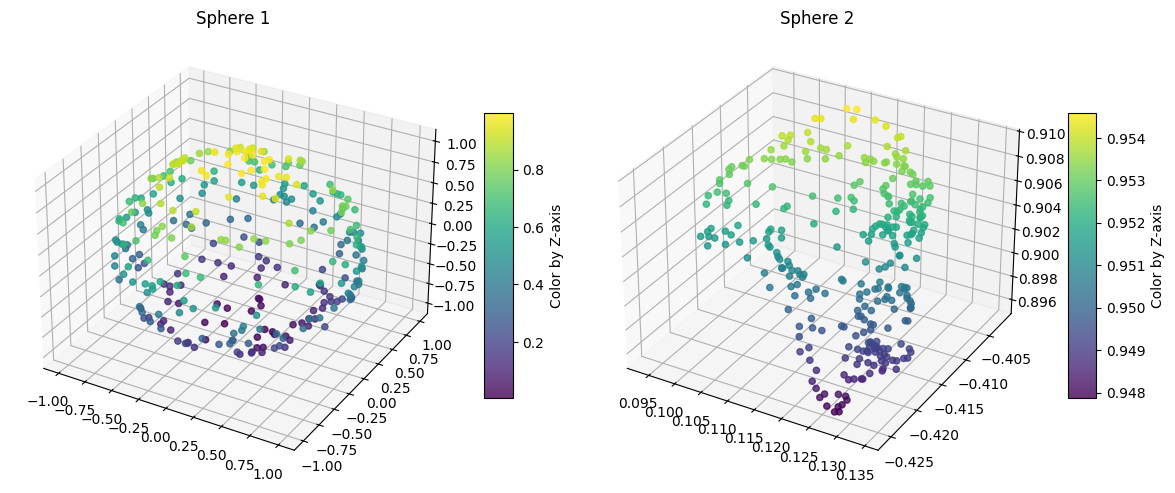

In [34]:
# Initialize data generation process
g = torch.nn.Identity()

# Initialize the multi-layer perceptron used for encoding
f = get_mlp(
    n_in=data_dimension,
    n_out=latent_dimension,
    layers=[
        3 * 10,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 10,
    ],
    output_normalization="fixed_sphere",
).to("cpu")

h = lambda z: f(g(z))

z = sphere.uniform(300)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z, z_enc)

In [ ]:
# Perform training

# encoder, decoder, sample_pair, sample_uniform, temperature

sample_pair_fixed = lambda batch: sphere.sample_pair_vmf(batch, kappa)
sample_uniform_fixed = lambda batch: sphere.uniform(batch)

simclr_vmf = SimCLR(
    f, g, sample_pair_fixed, sample_uniform_fixed, tau
)

f = simclr_vmf.train(batch, iterations)
h = lambda z: f(g(z))

z = sphere.uniform(1000)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z, z_enc)

Loss: 8.723374366760254 Samples processed: 1


In [17]:
normal_concentration_param = 0.05

f_normal = get_mlp(
    n_in=data_dimension,
    n_out=latent_dimension,
    layers=[
        3 * 10,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 10,
    ],
    output_normalization="fixed_sphere",
).to("cpu")

h_normal = lambda z: f_normal(g(z))

adam_normal = torch.optim.Adam(f_normal.parameters(), lr=1e-4)

loss_normal = SimCLRLoss(tau)

for i in range(iterations):
    z, z_sim = sphere.sample_pair_normal(batch, normal_concentration_param)
    
    z_neg = sphere.uniform(batch)
    z_enc = h_normal(z)
    z_enc_sim = h_normal(z_sim)
    z_enc_neg = h_normal(z_neg)
    loss_result = training_step(z_enc, z_enc_sim, z_enc_neg, adam_normal, loss_normal)
    
    if i % 250 == 1:
        print('Loss:', loss_result, 'Samples processed:', i)

z = sphere.uniform(1000)
z_enc = h_normal(z)
visualize_spheres_side_by_side(plt, z, z_enc)

Loss: 8.723389625549316 Samples processed: 1
Loss: 8.627887725830078 Samples processed: 251
Loss: 8.625715255737305 Samples processed: 501
Loss: 8.625822067260742 Samples processed: 751
Loss: 8.625616073608398 Samples processed: 1001


KeyboardInterrupt: 